## LIBRARIES

In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import string
from gensim.models import Word2Vec
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import WhitespaceTokenizer
from scipy.sparse import csr_matrix
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.utils import shuffle
from textblob import TextBlob
from xgboost import XGBClassifier
%matplotlib inline


## DATA PREPERATION

In [2]:
# Read CSV Dataset Files

fakedf = pd.read_csv('./dataset/Fake.csv')
truedf = pd.read_csv('./dataset/True.csv')

# Create 'target' for fake and real news

fakedf['target'] = 'fake'
truedf['target'] = 'true'

# Concatenate both DataFrames into a single dataset containing both real and fake news 

NewsData = pd.concat([fakedf, truedf]).reset_index(drop = True)

# Shuffle the data to prevent overfitting and dataset memorization

NewsData = shuffle(NewsData)
NewsData = NewsData.reset_index(drop=True)

#  Adjust columns in NewsData

NewsData['news']=NewsData['title']+NewsData['text']
NewsData=NewsData.drop(['title', 'text'], axis=1)
NewsData['date'].value_counts()

# Make Dataset Smaller for Faster Run Time

NewsData_S  = NewsData[:500]

# Place independent features in X variable 

X = NewsData_S.drop('target',axis =1)

# Place 'target' values (True or False) in y variable

y = NewsData_S['target']

# Create a copy of the adjusted dataset

NewsData_Adjusted = NewsData_S.copy()

# EXPLORATORY DATA ANALYSIS 

## Exploring word count of real and fake news

In [3]:
# Compute word-count for each news article

NewsData['word_count'] = NewsData['news'].apply(lambda x: len(str(x).split()))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


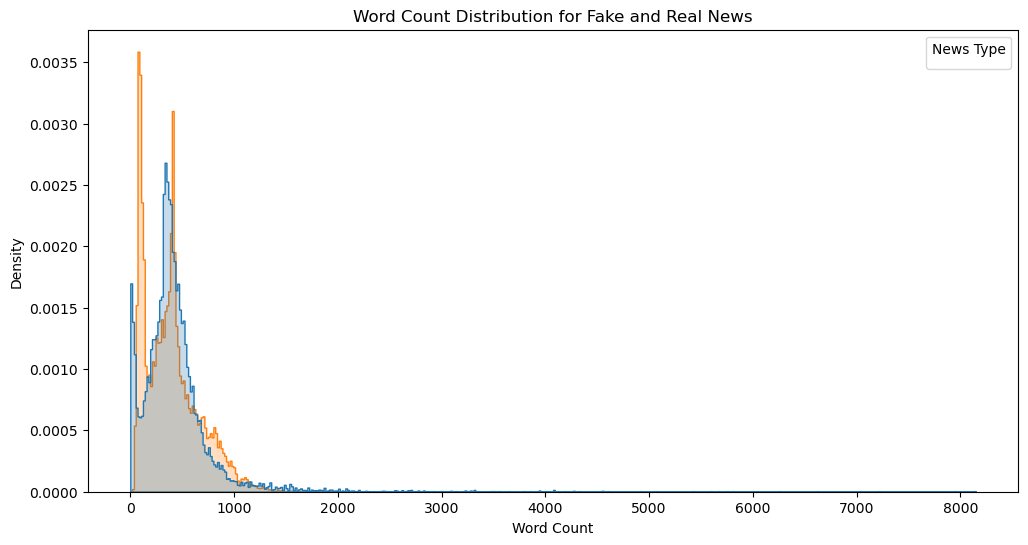

In [4]:
# Plotting word count between real and fake News

plt.figure(figsize=(12, 6))
sns.histplot(NewsData, x='word_count', hue='target', element='step', stat='density', common_norm=False)
plt.title('Word Count Distribution for Fake and Real News')
plt.xlabel('Word Count')
plt.ylabel('Density')
plt.legend(title='News Type')
plt.show()

## Exploring title length of real and fake news

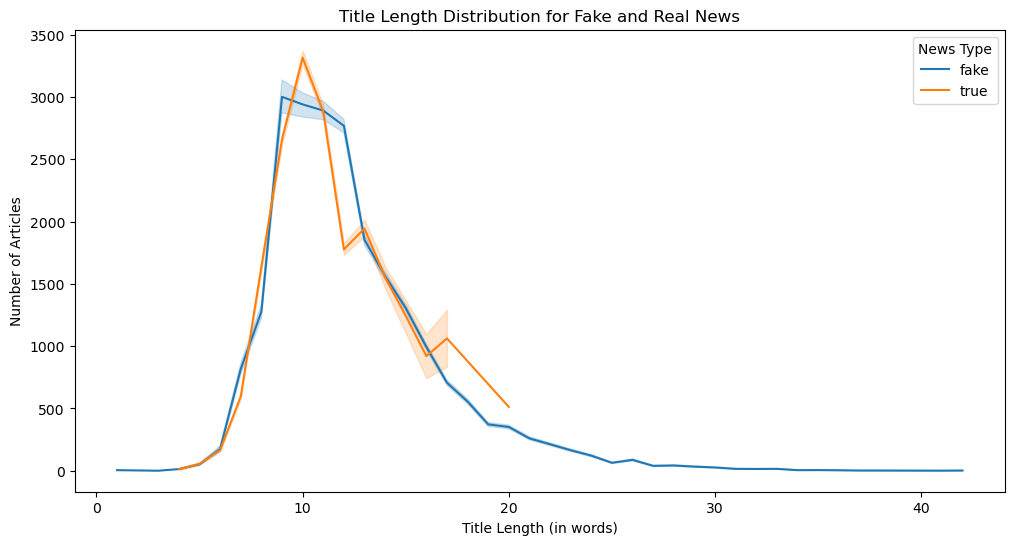

In [5]:
fakedf['title_length'] = fakedf['title'].apply(lambda x: len(str(x).split()))
truedf['title_length'] = truedf['title'].apply(lambda x: len(str(x).split()))

# Combine the dataframes for visualization

combined_df = pd.concat([fakedf, truedf])

# Sort by title length for a smoother line graph

combined_df = combined_df.sort_values(by="title_length").reset_index(drop=True)

# Plot Results

plt.figure(figsize=(12, 6))
sns.lineplot(data=combined_df, x='title_length', y=combined_df.groupby('title_length').cumcount(), hue='target')
plt.title('Title Length Distribution for Fake and Real News')
plt.xlabel('Title Length (in words)')
plt.ylabel('Number of Articles')
plt.legend(title='News Type')
plt.show()

## Exploring punctuation usage of real and fake news

In [6]:
# Extract Count Specfic Punctuation

def count_specific_punct(text, punct):
    return text.count(punct)

punctuation_list = ['.', ',', '?', '!', ':', ';']

for punct in punctuation_list:
    NewsData[punct] = NewsData['news'].apply(lambda x: count_specific_punct(x, punct))

# Calculate Mean Counts for Each Punctuation

mean_punctuation_counts = NewsData.groupby('target')[punctuation_list].mean().transpose()


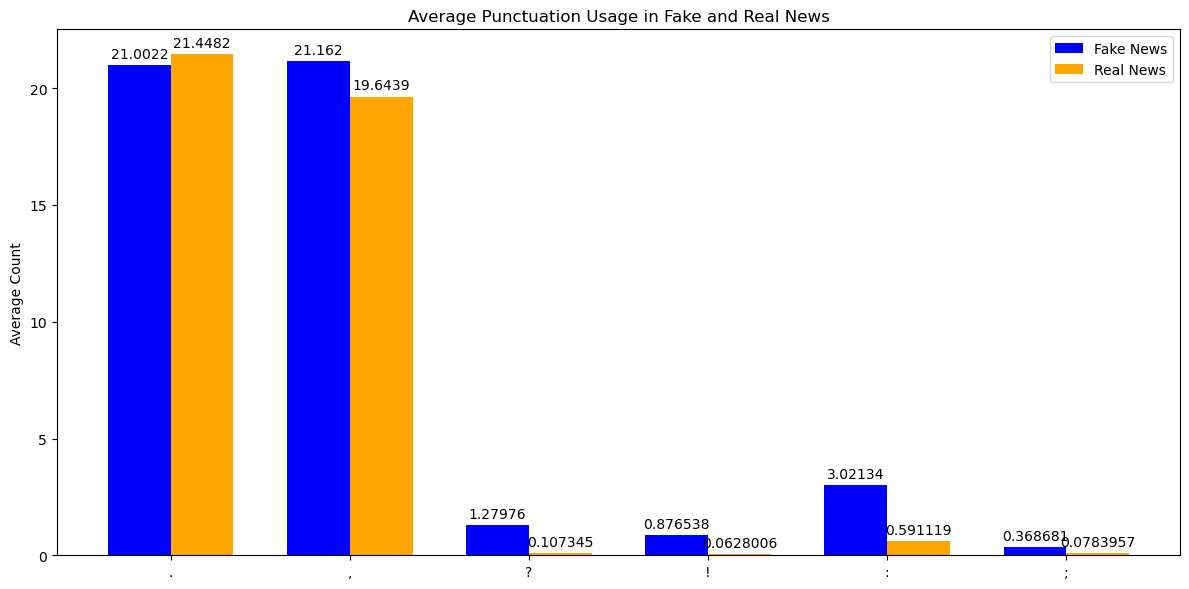

In [7]:
# Plot Results

labels = mean_punctuation_counts.index
fake_counts = mean_punctuation_counts['fake']
real_counts = mean_punctuation_counts['true']

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, fake_counts, width, label='Fake News', color='blue')
rects2 = ax.bar(x + width/2, real_counts, width, label='Real News', color='orange')

ax.set_ylabel('Average Count')
ax.set_title('Average Punctuation Usage in Fake and Real News')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()




## Explore Lexical Diversity

In [8]:
# Compute Lexical Diversity 

def lexical_diversity(text):
    words = text.split()
    if len(words) == 0:  # To prevent division by zero
        return 0
    return len(set(words)) / len(words)

NewsData['lexical_diversity'] = NewsData['news'].apply(lexical_diversity)

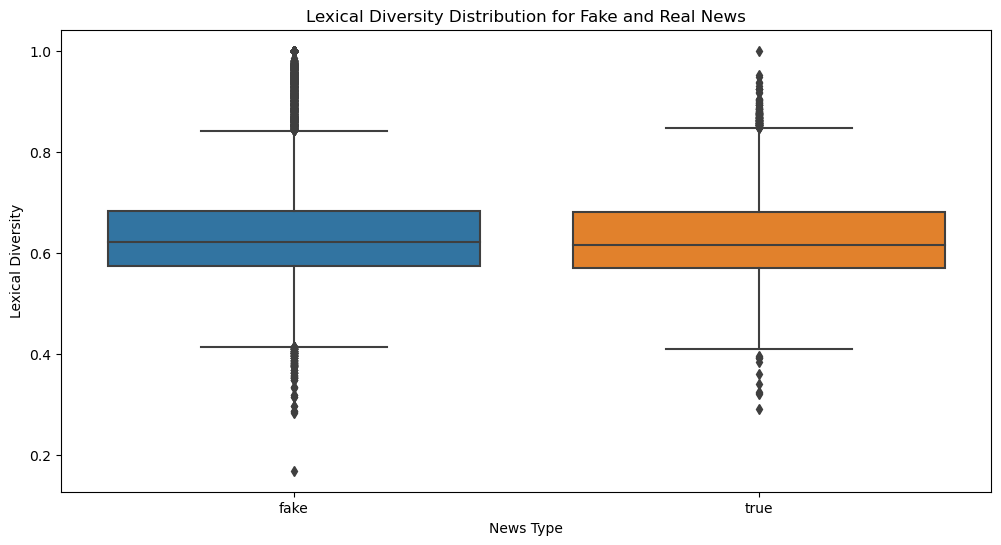

In [9]:
# Plot Results

plt.figure(figsize=(12, 6))
sns.boxplot(x='target', y='lexical_diversity', data=NewsData)
plt.title('Lexical Diversity Distribution for Fake and Real News')
plt.xlabel('News Type')
plt.ylabel('Lexical Diversity')
plt.show()

## Exploring Sentiment Analysis

In [10]:
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

In [11]:
NewsData['sentiment'] = NewsData['news'].apply(get_sentiment)


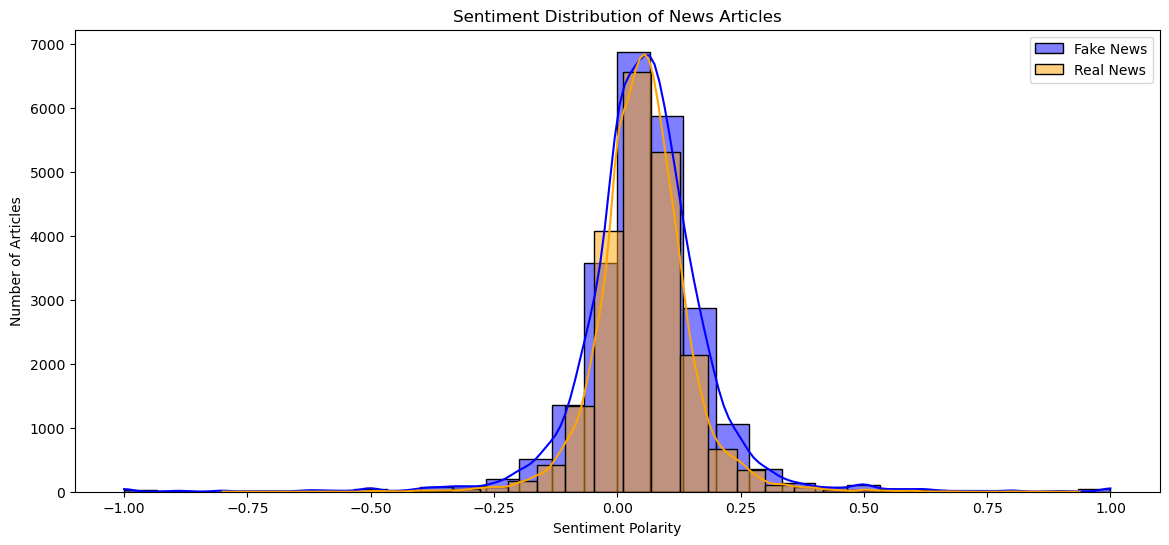

In [12]:
plt.figure(figsize=(14, 6))

# Plot sentiment for fake news
sns.histplot(NewsData[NewsData['target'] == 'fake']['sentiment'], color='blue', label='Fake News', bins=30, kde=True)

# Plot sentiment for real news
sns.histplot(NewsData[NewsData['target'] == 'true']['sentiment'], color='Orange', label='Real News', bins=30, kde=True)

plt.title('Sentiment Distribution of News Articles')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Number of Articles')
plt.legend()
plt.show()

## TOKENIZATION AND TEXT PREPROCESSING

In [13]:
port_S = PorterStemmer()
array_= []

for i in range(0, len(NewsData_Adjusted)):
      text_adj = re.sub('[^a-zA-Z]', ' ', NewsData_Adjusted['news'][i])
      text_adj = re.sub('https?://\S+|www\.\S+', '', NewsData_Adjusted['news'][i])
      text_adj = re.sub('<.*?>+', '', NewsData_Adjusted['news'][i])
      text_adj = re.sub('[%s]' % re.escape(string.punctuation), '', NewsData_Adjusted['news'][i])
      text_adj = re.sub('\n', '', NewsData_Adjusted['news'][i])
      text_adj = re.sub('\w*\d\w*', '', NewsData_Adjusted['news'][i])
      text_adj = text_adj.lower()
      text_adj = text_adj.split()
      text_adj = [port_S.stem(word) for word in text_adj if not word in stopwords.words('english')]
      text_adj = ' '.join(text_adj)
      array_.append(text_adj)



## BAG WORDS AND COUNT VECTORS

In [14]:
cv = CountVectorizer(max_features = 5000,ngram_range=(1,3))
X = cv.fit_transform(array_).toarray()
X.shape 
y =NewsData_Adjusted['target']

In [15]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.4,random_state = 0)

In [16]:
count_df = pd.DataFrame(X_train,columns = cv.get_feature_names_out())

## Model Builder and Graph Results

In [17]:
def evaluate_classifier(classifier, X_train, y_train, X_test, y_test, heatmap_color='Blues'):
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    
    # Evaluation of Results
    acc_score = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred, zero_division=0, pos_label='true')
    precision = precision_score(y_test, pred, zero_division=0, pos_label='true')
    recall = recall_score(y_test, pred, zero_division=0, pos_label='true')

    
    percent_conv = acc_score * 100
    print("Accuracy: %0.2f%%" % percent_conv)
    print("F1 Score:", f1)
    print("Precision:", precision)
    print("Recall:", recall)
    
    cf_matrix = confusion_matrix(y_test, pred)
    sns.heatmap(cf_matrix, annot=True, cmap=heatmap_color)
    plt.show()

# MultinomialNB

Accuracy: 93.00%
F1 Score: 0.9195402298850575
Precision: 0.9411764705882353
Recall: 0.898876404494382


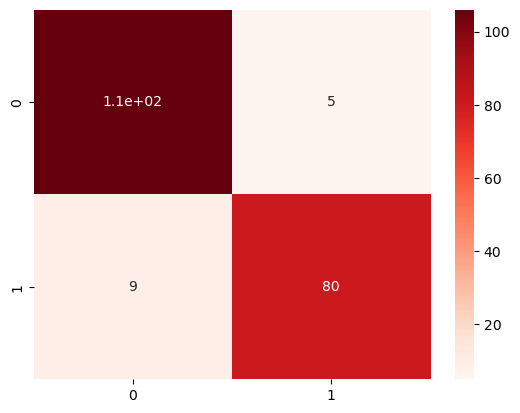

In [18]:
MultinomialNB_classifier = MultinomialNB()
evaluate_classifier(MultinomialNB_classifier, X_train, y_train, X_test, y_test, heatmap_color='Reds')

# kNN Classification

Accuracy: 69.00%
F1 Score: 0.5441176470588235
Precision: 0.7872340425531915
Recall: 0.4157303370786517


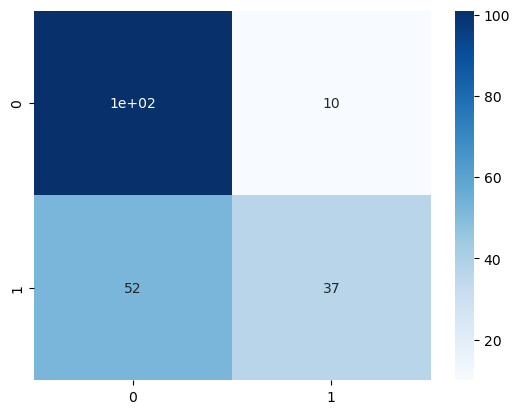

In [19]:
knn_classifier = KNeighborsClassifier()
evaluate_classifier(knn_classifier, X_train, y_train, X_test, y_test, heatmap_color='Blues')

# Logistic Regression 

Accuracy: 94.00%
F1 Score: 0.9347826086956522
Precision: 0.9052631578947369
Recall: 0.9662921348314607


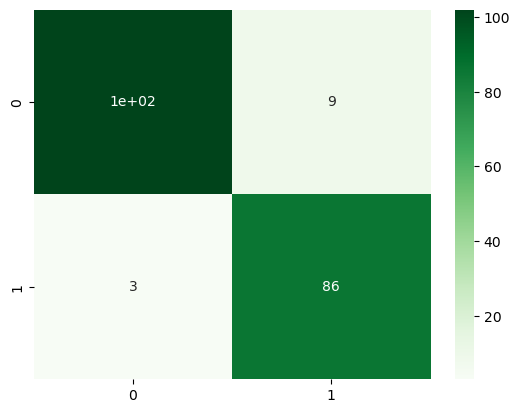

In [20]:
logreg_classifier = LogisticRegression()
evaluate_classifier(logreg_classifier, X_train, y_train, X_test, y_test, heatmap_color = "Greens")

# Random Forest Classifier

Accuracy: 98.00%
F1 Score: 0.9772727272727273
Precision: 0.9885057471264368
Recall: 0.9662921348314607


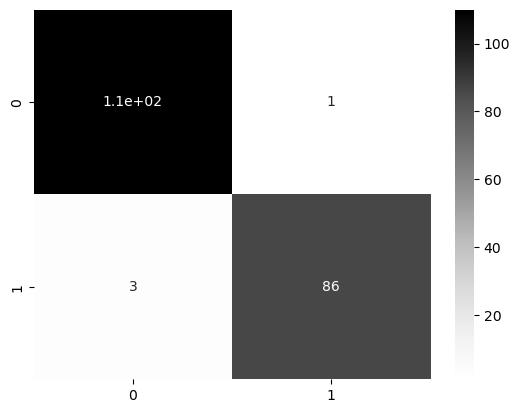

In [21]:
rfc = RandomForestClassifier(n_estimators = 600, bootstrap = True, random_state=8)
evaluate_classifier(rfc, X_train, y_train, X_test, y_test, heatmap_color = "Greys")

# Passive Agressive Classifier

Accuracy: 94.50%
F1 Score: 0.9405405405405405
Precision: 0.90625
Recall: 0.9775280898876404


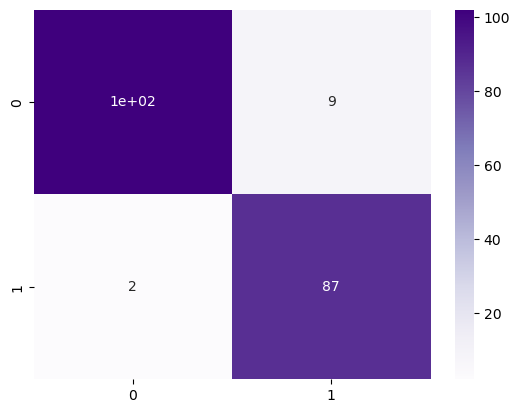

In [22]:
pac = PassiveAggressiveClassifier()
evaluate_classifier(pac, X_train, y_train, X_test, y_test, heatmap_color = "Purples")

## Models from Scratch

In [23]:
class MultinomialNB:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        
    def fit(self, X, y):
        m, n = X.shape
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)
    
        # Create a mapping from class label to index
        self.class_to_index_ = {label: index for index, label in enumerate(self.classes_)}
    
        self.class_probs_ = np.zeros(n_classes)
        self.feature_probs_ = np.zeros((n_classes, n))

        # Class probabilities: P(y = c)
        for c in self.classes_:
            class_idx = self.class_to_index_[c]  # Use the mapping here
            self.class_probs_[class_idx] = np.sum(y == c) / m 

        # Conditional probabilities: P(x_i|y = c)
        for c in self.classes_:
            class_idx = self.class_to_index_[c]  # Use the mapping here
            X_c = X[y == c]
            self.feature_probs_[class_idx] = (X_c.sum(axis=0) + self.alpha) / (np.sum(X_c.sum(axis=0) + self.alpha))

        return self

    def predict(self, X):
        return [self._predict(x) for x in X]

    def _predict(self, x):
        posteriors = []

        # Calculate posterior probability for each class
        for idx, c in enumerate(self.classes_):
            prior = np.log(self.class_probs_[idx])
            cond_prob = sum(np.log(self.feature_probs_[idx][x == 1]))  # Use feature_probs_ here instead of cond_probs_
            posterior = prior + cond_prob
            posteriors.append(posterior)

        # Return class with highest posterior probability
        return self.classes_[np.argmax(posteriors)]

    
class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        # Compute distances between x and all examples in the training set
        distances = [np.sqrt(np.sum((x - x_train)**2)) for x_train in self.X_train]
        
        # Sort by distance and return indices of the first k neighbors
        k_indices = np.argsort(distances)[:self.k]
        
        # Extract the labels of the k nearest neighbor training samples
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        
        # Return the most common class label
        most_common = np.bincount(k_nearest_labels).argmax()
        return most_common
 



In [32]:
class LogisticRegressionModel:
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None
        
    def predict_proba(self, X):
        # Linear function
        linear = np.dot(X, self.weights) + self.bias
        # Sigmoid activation function
        return 1 / (1 + np.exp(-linear))
    
    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)
    
    def fit(self, X, y):
        m = X.shape[0]
        y = y.values.reshape(-1, 1)  # Ensuring y is a column vector and converting Series to NumPy array
        
        # Initialize weights and bias
        self.weights = np.zeros((X.shape[1], 1))
        self.bias = 0
        
        for i in range(self.num_iterations):
            predictions = self.predict_proba(X)
            
            dw = (1/m) * np.dot(X.T, (predictions - y))
            db = (1/m) * np.sum(predictions - y)
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db


In [25]:
def evaluate_classifier_scratch(classifier, X_train, y_train, X_test, y_test, heatmap_color='Blues'):
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)

    # Evaluation of Results
    acc_score = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred, zero_division=0, pos_label=true_label)
    precision = precision_score(y_test, pred, zero_division=0, pos_label=true_label)
    recall = recall_score(y_test, pred, zero_division=0, pos_label=true_label)

    print(f"Acc: {acc_score * 100:.2f}%")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    cf_matrix = confusion_matrix(y_test, pred)
    sns.heatmap(cf_matrix, annot=True, cmap=heatmap_color)
    plt.show()

# MultinomialNB (from scratch)


Accuracy: 95.50%
F1 Score: 0.9497206703910613
Precision: 0.9444444444444444
Recall: 0.9550561797752809


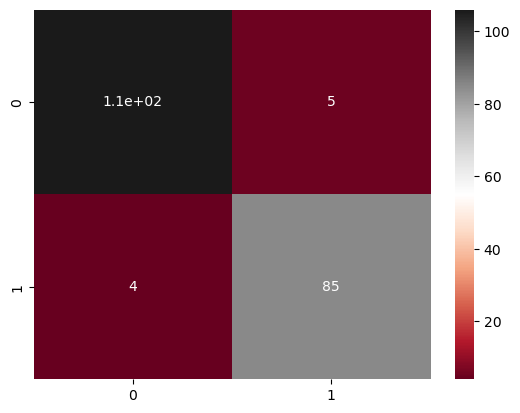

In [26]:
mnb_classifier = MultinomialNB(alpha=1.0)
evaluate_classifier(mnb_classifier, X_train, y_train, X_test, y_test, heatmap_color='RdGy')

# kNN Classification (from Scratch)

Acc: 68.00%
F1 Score: 0.5294
Precision: 0.7660
Recall: 0.4045


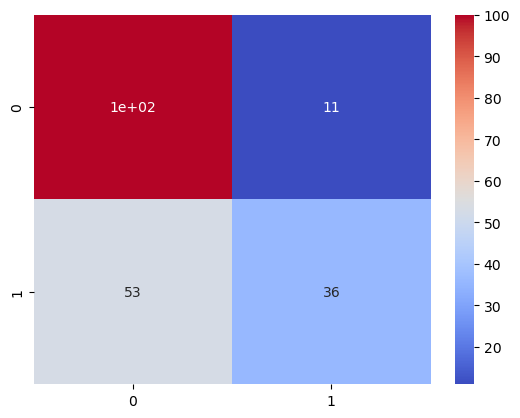

In [27]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)
true_label = le.transform(['true'])[0]

knn_classifier = KNN(k=3)
evaluate_classifier_scratch(knn_classifier, X_train, y_train_encoded, X_test, y_test_encoded, heatmap_color='coolwarm')


# Logistic Regression (from Scratch)

In [33]:
NewsData_Adjusted['target'] = NewsData_Adjusted['target'].replace({'fake': 0, 'true': 1})
NewsData_Adjusted['target'].head()
y =NewsData_Adjusted['target']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.4,random_state = 0)


In [34]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (300, 5000)
y_train shape: (300,)
X_test shape: (200, 5000)
y_test shape: (200,)


Acc: 93.50%
F1 Score: 0.9290
Precision: 0.9043
Recall: 0.9551


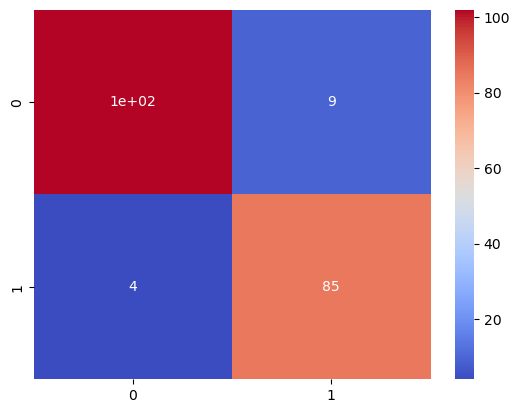

In [35]:
# Initialize the model
model = LogisticRegressionModel(learning_rate=0.01, num_iterations=1000)
evaluate_classifier_scratch(model, X_train, y_train, X_test, y_test, heatmap_color='coolwarm')



# REFERENCES

## [1] Bisaillon, C. (n.d.). Fake and Real News Dataset. Retrieved May 7, 2023, from https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset
